ウィルス分布のデータを作成する。

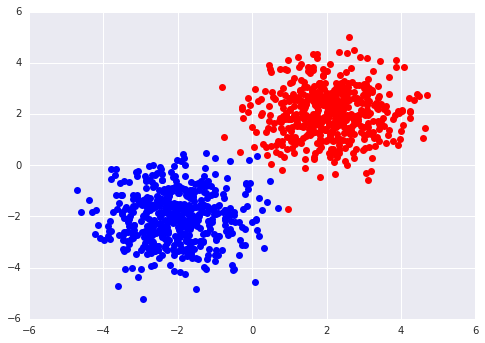

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_positive = np.random.randn(500, 1) + 2
y_positive = np.random.randn(500, 1) + 2
x_negative = np.random.randn(500, 1) - 2
y_negative = np.random.randn(500, 1) - 2

plt.figure(1)
plt.plot(x_positive, y_positive, 'ro', label='Data1')
plt.plot(x_negative, y_negative, 'bo', label='Data2')

感染、非感染の(x,y)座標を1つのデータに結合する

In [5]:
N = len(x_positive)
POSITIVE = np.zeros((N,2))
for i in xrange(N):
  POSITIVE[i][0] = x_positive[i]
  POSITIVE[i][1] = y_positive[i]

NEGATIVE = np.zeros((N,2))
for i in xrange(N):
  NEGATIVE[i][0] = x_negative[i]
  NEGATIVE[i][1] = y_negative[i]

VIRUS = np.vstack([NEGATIVE, POSITIVE]).astype(np.float32)

print VIRUS

[[-2.52602124 -1.5560869 ]
 [-0.98754537 -0.33516634]
 [-2.24593019 -1.59417355]
 ..., 
 [ 0.37142265  1.30117118]
 [ 1.23769999  4.22338676]
 [ 1.29728305  1.51972091]]


各データにラベル付けをする。ウイルス感染のラベルを[0,1]、ウイルス非感染のラベルを[1,0]にする

In [6]:
STATE = np.zeros((N*2,2), dtype=np.float32)
for i in xrange(N*2):
  if i < N:
    STATE[i][1] = 1
  else:
    STATE[i][0] = 1

print STATE

[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


それでは、ここからTensorFlowで結果を求める。

In [7]:
tf.reset_default_graph()
LOGDIR = "./data_virus"
 
x = tf.placeholder(tf.float32, shape=(None,2), name="input")
y = tf.placeholder(tf.float32, shape=(None,2), name="output")
w = tf.Variable(tf.random_normal([2,2], stddev=0.01), dtype=tf.float32, name="weight")
b = tf.Variable(tf.random_normal([2], stddev=0.01), dtype=tf.float32, name="bias")

ロジスティック回帰のモデルを定義する

In [8]:
with tf.name_scope('forward'):
  y_pred = tf.nn.softmax(tf.matmul(x,w) + b, name="forward")

コストの定義をする

In [9]:
with tf.name_scope('cost'):
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred)
  cost = tf.reduce_mean(loss, 0)

精度の定義をする

In [10]:
with tf.name_scope('accuracy'):
  correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(STATE,1))
  accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

TensorBoardへの反映

In [11]:
# TensorBoardへの反映
w_graph = tf.summary.histogram("W_graph", w)
b_graph = tf.summary.histogram("b_graph", b)
y_graph = tf.summary.histogram("y_graph", y)
cost_graph = tf.summary.scalar("cost_graph", cost)

トレーニングの設定をする

In [12]:
with tf.Session() as sess:
  # 初期化処理
  init_op = tf.global_variables_initializer()
  sess.run(init_op)

  # トレーニング
  learning_rate = 0.01
  train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

  # Summary
  summary_writer = tf.summary.FileWriter(LOGDIR, sess.graph)
  summary_op = tf.summary.merge_all()
  
  with tf.Graph().as_default():
    # トレーニング回数
    training_step = 1000
    validation_step = 100

    # トレーニング
    for step in xrange(training_step):
      sess.run(train_op, feed_dict={x: VIRUS, y: STATE})

      if step % validation_step == 0:
        accuracy_output,cost_output = sess.run([accuracy_op,cost], feed_dict={x: VIRUS, y: STATE})
        print "step %d, cost %f, accuracy %f" % (step,cost_output,accuracy_output)
        
        # TensorBoardにも反映
        summary_str = sess.run(summary_op, feed_dict={x: VIRUS, y: STATE})
        summary_writer.add_summary(summary_str, step)
            
    summary_writer.flush()

step 0, cost 0.680736, accuracy 0.981000
step 100, cost 0.394187, accuracy 0.997000
step 200, cost 0.362436, accuracy 0.997000
step 300, cost 0.350282, accuracy 0.997000
step 400, cost 0.343721, accuracy 0.997000
step 500, cost 0.339558, accuracy 0.997000
step 600, cost 0.336656, accuracy 0.997000
step 700, cost 0.334504, accuracy 0.997000
step 800, cost 0.332835, accuracy 0.997000
step 900, cost 0.331499, accuracy 0.997000


再計算時はフォルダを消す(TensorFlowを実行する前に消す事)

In [1]:
!rm -r ./data_virus

TensorBoardを起動

Datalabでは、TensorBoardをForground実行しかできないので、プロセスの停止は、メニューの[Reset Session]でResetを選ぶ事で停止する

In [ ]:
!tensorboard --logdir=data_virus/

Starting TensorBoard 41 on port 6006
(You can navigate to http://172.17.0.2:6006)
